# Notebook Summary


In [1]:
import numpy as np
import os
import pandas as pd
import re
import gc 
import random
import os
from random import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)

In [2]:
def df_to_np(df): #convert df to np array, seperate labels and attack
    X = df.iloc[:,0:-2].to_numpy()
    y = df.iloc[:,-2:].to_numpy()
    return X, y
    
def seperate_label_attack(y):
    a = y[:,0]
    y = np.asarray(y[:,1]).astype('int8')
    return y, a

def split_train_val(df, val_ratio):
    df_val = df[df['Attack']=='Benign'].sample(frac=(val_ratio/2))
    df_val = pd.concat([df_val, df[df['Attack']!='Benign'].sample(frac=(val_ratio/2))], axis=0)
    df.drop(df_val.index, inplace=True)
    #df.reset_index(drop=True, inplace=True)
    #df_val.reset_index(drop=True, inplace=True)
    return df_val, df

def bgta_ub(df, r, p): #benign count gt anomaly count distribution for BoT-IoT
    df_tr = df[df['Label']==1]
    if p == 1:
        total_benign = int(round(len(df_tr.index)/(1-r))*(r))
    else:
        total_benign = int(round(((len(df_tr.index)/(1-r))*(r)*p)))
    df_tr = pd.concat([df_tr, df[df['Label'] == 0].sample(n=total_benign)], axis=0)
    df.drop(df_tr.index, inplace=True)
    return df, df_tr

def agtb_ub(df, attacks, r, p): #benign count gt anomaly count
    tot_dist = df['Label'].value_counts()
    df_tr = df[df['Label']==0]
    total_anomaly = int(round(len(df_tr.index)/r)*(1-r))
    f = total_anomaly/(tot_dist[1])
    for attack in attacks:
        if attack == 'DDoS':
            df_tr = pd.concat([df_tr, df[df['Attack'] == attack].sample(frac=f)], axis=0)
        else:
            df_tr = pd.concat([df_tr, df[df['Attack'] == attack].sample(frac=f)], axis=0)
    if p < 1:
        df_tr.drop((df_tr[df_tr['Label']==0].sample(frac=(1-p))).index, inplace=True)
    df.drop(df_tr.index, inplace=True)
    return df, df_tr

def balance_dataset(df): #balance all attack categories for training
    attacks = df[df['Attack'] != 'Benign']['Attack'].unique()
    value_c = df[df['Attack'] != 'Benign']['Attack'].value_counts()
    tot_dist = df['Label'].value_counts()
    print('Splitting Datasets')
    if tot_dist[0] > tot_dist[1]:
        df, df_tr = bgta(df, attacks, value_c)
    else:
        df, df_tr = agtb(df, attacks, value_c)
    return df, df_tr

def unbalance_train(df, r, p, max_borrowed_samples):
    attacks = df[df['Attack'] != 'Benign']['Attack'].unique()
    value_c = df[df['Attack'] != 'Benign']['Attack'].value_counts()
    tot_dist = df['Label'].value_counts()
    if p > 0:
        if tot_dist[0] > tot_dist[1]:
            df, df_tr = bgta_ub(df, r, p)
        else:
            df, df_tr = agtb_ub(df, attacks, r, p)
    if p == 0:
        df_tr = pd.DataFrame()
        for attack in attacks:
            try:
                df_tr = pd.concat([df_tr, df[df['Attack'] == attack].sample(n=round((max_borrowed_samples*((1-r)/r)*0.33)/len(attacks)))], axis=0)
            except:
                df_tr = pd.concat([df_tr, df[df['Attack'] == attack]], axis=0)
        df.drop(df_tr.index, inplace=True)
    return df, df_tr

In [3]:
#isolate               0              1                              2                 3
files = ['NF-BoT-IoT-v2.csv', 'NF-CSE-CIC-IDS2018-v2.csv', 'NF-ToN-IoT-v2b.csv', 'NF-UNSW-NB15-v2.csv']
isolate = 1
val_ratio = 0.25
r = 0.8 #benign to anomaly ratio
p = 0 # ratio of original benign to total benign in dataset. p=1:dont mix, dont replace, p=0:replace all original benign with test data, 0<p<1:mix data to ratio of p
folder= 'rboa/' #folder to save dataset to
dir = '../../../Datasets/NF-UQ-NIS-2/Original Dataset/' #original dataset directory
max_borrowed_samples = 5000000 #borrowed samples from testing data for training data, mixed/replaced benign scenario
oboa_dir = 'oboa/'

d = {#'L4_SRC_PORT': np.int32,
  'L4_DST_PORT': np.int32,
  'PROTOCOL': np.int32,
 'L7_PROTO': np.float64,
  'IN_BYTES': np.int32,
#  'IN_PKTS': np.int32,
#  'OUT_BYTES': np.int32,
#  'OUT_PKTS': np.int32,
#  'TCP_FLAGS': np.int32,
#  'CLIENT_TCP_FLAGS': np.int32,
#  'SERVER_TCP_FLAGS': np.int32,
 'FLOW_DURATION_MILLISECONDS': np.int32,
 'DURATION_IN': np.int32,
#  'DURATION_OUT': np.int32,
#  'MIN_TTL': np.int32,
#  'MAX_TTL': np.int32,
#  'LONGEST_FLOW_PKT': np.int32,
#  'SHORTEST_FLOW_PKT': np.int32,
#  'MIN_IP_PKT_LEN': np.int32,
#  'MAX_IP_PKT_LEN': np.int32,
# 'SRC_TO_DST_SECOND_BYTES': np.float64,
# 'DST_TO_SRC_SECOND_BYTES': np.float64,
#  'RETRANSMITTED_IN_BYTES': np.int32,
#  'RETRANSMITTED_IN_PKTS': np.int32,
#  'RETRANSMITTED_OUT_BYTES': np.int32,
#  'RETRANSMITTED_OUT_PKTS': np.int32,
#  'SRC_TO_DST_AVG_THROUGHPUT': np.int32,
#  'DST_TO_SRC_AVG_THROUGHPUT': np.int32,
#  'NUM_PKTS_UP_TO_128_BYTES': np.int32,
#  'NUM_PKTS_128_TO_256_BYTES': np.int32,
#  'NUM_PKTS_256_TO_512_BYTES': np.int32,
#  'NUM_PKTS_512_TO_1024_BYTES': np.int32,
#  'NUM_PKTS_1024_TO_1514_BYTES': np.int32,
  'TCP_WIN_MAX_IN': np.int32,
  'TCP_WIN_MAX_OUT': np.int32,
#  'ICMP_TYPE': np.int32,
#  'ICMP_IPV4_TYPE': np.int32,
#  'DNS_QUERY_ID': np.int32,
#  'DNS_QUERY_TYPE': np.int32,
#  'DNS_TTL_ANSWER': np.int32,
#  'FTP_COMMAND_RET_CODE': np.int32
    }

headers = list(d.keys())
headers.extend(('Attack', 'Label'))

print('Isolating: {0}'.format(files[isolate]))
isolated = files[isolate]
files.pop(isolate)
print(files)

Isolating: NF-CSE-CIC-IDS2018-v2.csv
['NF-BoT-IoT-v2.csv', 'NF-ToN-IoT-v2b.csv', 'NF-UNSW-NB15-v2.csv']


In [4]:
df = pd.read_csv(oboa_dir+'3_train.csv', dtype=d)
print('Training: Total Original Samples Before Dropping:', (len(df[df['Label']==0].index)))
tr_ben_samples = tr_ben_samples = len(df[df['Label']==0].index)
df.drop(df[df['Label']==0].sample(frac=1).index, inplace=True)
df.to_csv(folder+'3_train.csv', header=headers, index=None)

df = pd.read_csv(oboa_dir+'3_val.csv', dtype=d)
print('Validation: Total Original Samples Before Dropping:', (len(df[df['Label']==0].index)))
val_ben_samples = round(len(df[df['Label']==0].index)/2)
df.drop(df[df['Label']==0].sample(frac=1).index, inplace=True)
df.to_csv(folder+'3_val.csv', header=headers, index=None)

df = pd.read_csv(oboa_dir+'3_test.csv', dtype=d)
print('Test: Total Original Samples Before Dropping:', (len(df[df['Label']==0].index)))
test_ben_samples = val_ben_samples
df.drop(df[df['Label']==0].sample(frac=1).index, inplace=True)
df.to_csv(folder+'3_test.csv', header=headers, index=None)

new_test_file = 'rb_r'+str(r)[2:]+'_'+isolated

print('Borrowing samples for replacement:',tr_ben_samples, val_ben_samples, test_ben_samples)
df = pd.read_csv(dir+isolated, usecols=['Label'])
df_1b_index_tr = df[df['Label']==0].sample(n=tr_ben_samples)
df.drop(df_1b_index_tr.index, inplace=True)
df_1b_index_val = df[df['Label']==0].sample(n=val_ben_samples)
df.drop(df_1b_index_val.index, inplace=True)
df_1b_index_test = df[df['Label']==0].sample(n=test_ben_samples)
df.drop(df_1b_index_test.index, inplace=True)
df_1b_index_tr = df_1b_index_tr.index.to_list()
df_1b_index_val = df_1b_index_val.index.to_list()
df_1b_index_test = df_1b_index_test.index.to_list()
pd.DataFrame(columns=headers).to_csv(folder+new_test_file, header=headers, index=None)


for chunk in pd.read_csv(dir+isolated, usecols=headers, chunksize=10000000, iterator=True):
    train_data = pd.Index([n for n in df_1b_index_tr if n in range(chunk.index.start,chunk.index.stop)])
    val_data =  pd.Index([n for n in df_1b_index_val if n in range(chunk.index.start,chunk.index.stop)])
    test_data = pd.Index([n for n in df_1b_index_test if n in range(chunk.index.start,chunk.index.stop)])
    chunk.loc[train_data].to_csv(folder+'3_train.csv', mode = 'a', header=None, index=0)
    chunk.loc[val_data].to_csv(folder+'3_val.csv', mode = 'a', header=None, index=0)
    chunk.loc[test_data].to_csv(folder+'3_test.csv', mode = 'a', header=None, index=0)
    
    chunk.drop(index = train_data, inplace=True)
    chunk.drop(index = val_data, inplace=True)
    chunk.drop(index = test_data, inplace=True)
    chunk.to_csv(folder+new_test_file, mode = 'a', header=None, index=0)
    print('done')

Training: Total Original Samples Before Dropping: 5787878
Validation: Total Original Samples Before Dropping: 826840
Test: Total Original Samples Before Dropping: 1915010
Borrowing samples for replacement: 5787878 413420 413420
done
done


3_train.csv

p: 0.8000001658639313


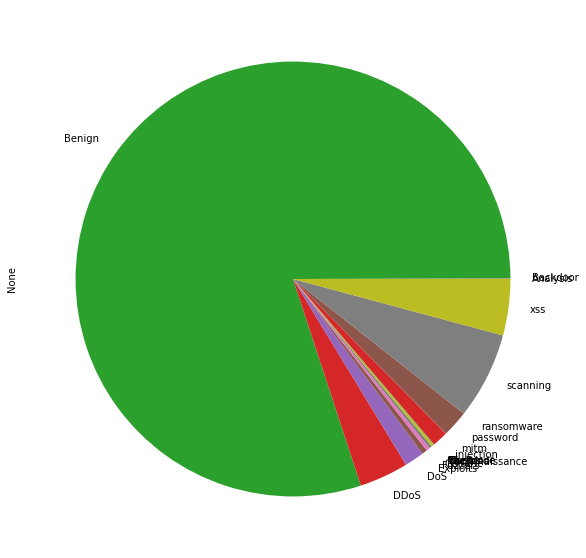

Attack
Analysis             2032
Backdoor             1923
Benign            5787878
DDoS               263665
DoS                105834
Exploits            27637
Fuzzers             19452
Generic             14465
Reconnaissance      13291
Shellcode            1241
Theft                   2
Worms                 144
backdoor             2044
injection           84169
mitm                  951
password           141837
ransomware            415
scanning           465405
xss                302461
dtype: int64

-------------------------------------
3_val.csv

p: 0.6666666666666666


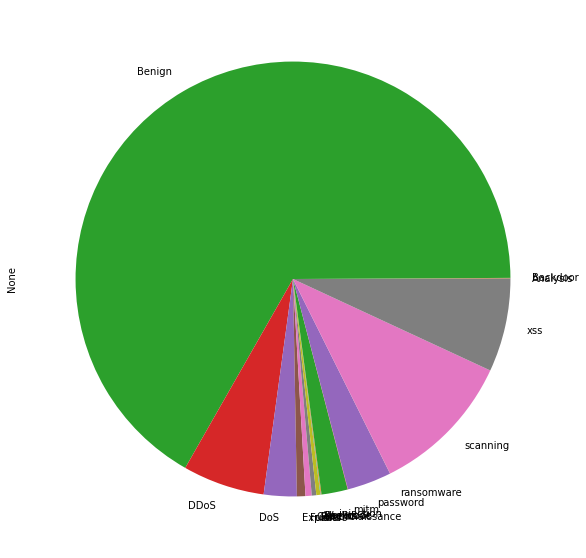

Attack
Analysis             267
Backdoor             246
Benign            413420
DDoS               37786
DoS                15152
Exploits            3914
Fuzzers             2858
Generic             2095
Reconnaissance      1839
Shellcode            186
Worms                 20
backdoor             320
injection          12106
mitm                 135
password           20386
ransomware            67
scanning           66478
xss                42855
dtype: int64

-------------------------------------
3_test.csv

p: 0.4633859838685814


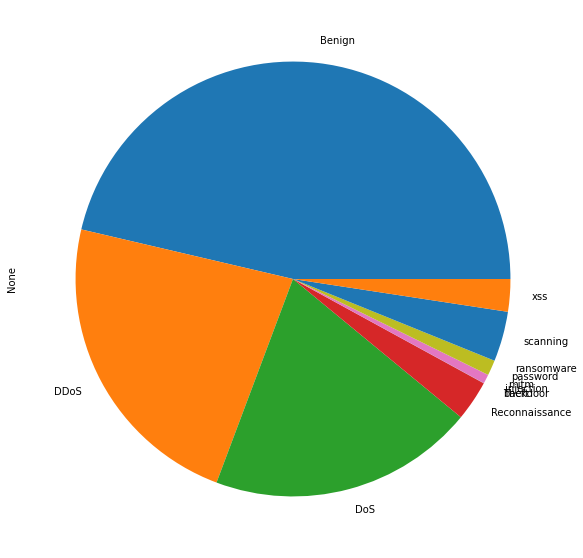

Attack
Benign            413420
DDoS              204689
DoS               176256
Reconnaissance     26725
Theft                 25
backdoor             147
injection           6003
mitm                  68
password           10115
ransomware            30
scanning           33163
xss                21531
dtype: int64

-------------------------------------


In [5]:
files = ['3_train.csv','3_val.csv', '3_test.csv']
for file in files:
    print(file+'\n')
    df = pd.read_csv(folder+file, usecols=['Label','Attack'])
    print('p:', str(len(df[df['Label'] == 0].index)/len(df.index)))
    count_series = df.groupby(['Attack']).size()
    count_series.plot(kind='pie', figsize=(10,10))
    plt.show()
    print(count_series)
    print('\n-------------------------------------')
    del df
    gc.collect()

In [6]:
files.remove('3_train.csv')
for file in files:
    X = pd.read_csv(folder+file, usecols=list(d.keys()))#, dtype=d
    y = pd.read_csv(folder+file, usecols=['Label'], dtype=np.int8)
    total_anomaly = len(y[y['Label']==1].index)
    total_benign = round((r/(1-r))*total_anomaly)
    print(str(total_anomaly), str(total_benign))
    alpha = {1:total_anomaly, 0:total_benign}
    sm = SMOTE(sampling_strategy=alpha, n_jobs=4)
    print('SMOTE')
    X, y = sm.fit_resample(X, y)
    print('SMOTE Done')
    a = pd.read_csv(folder+file, usecols=['Attack'])
    df = pd.concat([X, a, y], axis=1)
    df['Attack'].replace('', 'Benign')
    df.to_csv(folder+file, header=headers, index=0)

206710 826840
SMOTE


C:\Users\Will\anaconda3\envs\tf-gpu\lib\site-packages\imblearn\utils\_validation.py:299: UserWarning: After over-sampling, the number of samples (826840) in class 0 will be larger than the number of samples in the majority class (class #0 -> 413420)
  warnings.warn(


SMOTE Done
478752 1915008
SMOTE


C:\Users\Will\anaconda3\envs\tf-gpu\lib\site-packages\imblearn\utils\_validation.py:299: UserWarning: After over-sampling, the number of samples (1915008) in class 0 will be larger than the number of samples in the majority class (class #1 -> 478752)
  warnings.warn(


SMOTE Done


3_train.csv

p: 0.8000001658639313


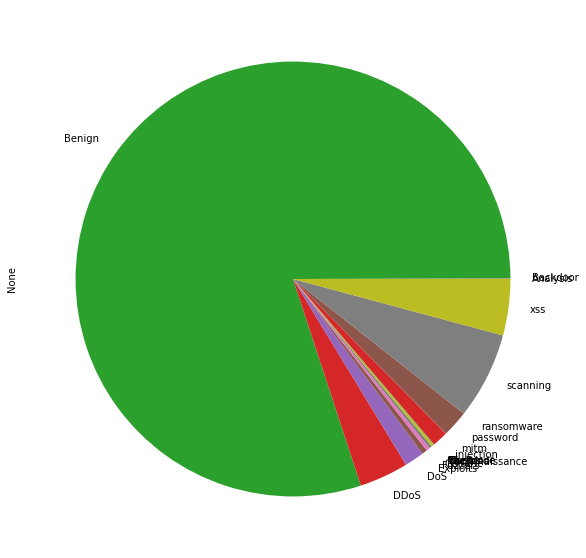

Attack
Analysis             2032
Backdoor             1923
Benign            5787878
DDoS               263665
DoS                105834
Exploits            27637
Fuzzers             19452
Generic             14465
Reconnaissance      13291
Shellcode            1241
Theft                   2
Worms                 144
backdoor             2044
injection           84169
mitm                  951
password           141837
ransomware            415
scanning           465405
xss                302461
dtype: int64

-------------------------------------
3_val.csv



C:\Users\Will\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


p: 0.8


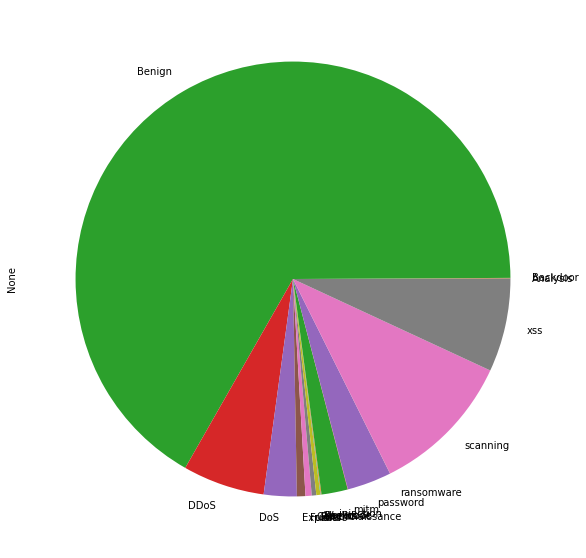

Attack
Analysis             267
Backdoor             246
Benign            413420
DDoS               37786
DoS                15152
Exploits            3914
Fuzzers             2858
Generic             2095
Reconnaissance      1839
Shellcode            186
Worms                 20
backdoor             320
injection          12106
mitm                 135
password           20386
ransomware            67
scanning           66478
xss                42855
dtype: int64

-------------------------------------
3_test.csv

p: 0.8


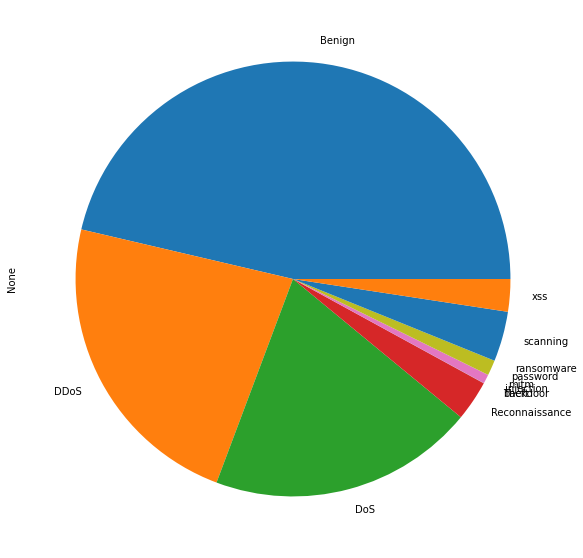

Attack
Benign            413420
DDoS              204689
DoS               176256
Reconnaissance     26725
Theft                 25
backdoor             147
injection           6003
mitm                  68
password           10115
ransomware            30
scanning           33163
xss                21531
dtype: int64

-------------------------------------


In [7]:
files = ['3_train.csv','3_val.csv', '3_test.csv']
for file in files:
    print(file+'\n')
    df = pd.read_csv(folder+file, usecols=['Label','Attack'])
    print('p:', str(len(df[df['Label'] == 0].index)/len(df.index)))
    count_series = df.groupby(['Attack']).size()
    count_series.plot(kind='pie', figsize=(10,10))
    plt.show()
    print(count_series)
    print('\n-------------------------------------')
    del df
    gc.collect()

In [4]:
scaler = StandardScaler()

print('Generating training data numpy arrays')
X, y = df_to_np(pd.read_csv(folder+'3_train.csv', dtype=d).sample(frac=1))
X = scaler.fit_transform(X)
y, a = seperate_label_attack(y)
np.save(folder+'X_train.npy', X)
np.save(folder+'y_train.npy', y)

print('Generating validation data numpy arrays')
X, y = df_to_np(pd.read_csv(folder+'3_val.csv', dtype=d).sample(frac=1))
X = scaler.transform(X)
y, a = seperate_label_attack(y)
np.save(folder+'X_val.npy', X)
np.save(folder+'y_val.npy', y)

print('Generating test data numpy arrays')
X, y = df_to_np(pd.read_csv(folder+'3_test.csv', dtype=d).sample(frac=1))
X = scaler.transform(X)
y, a = seperate_label_attack(y)
np.save(folder+'X_test.npy', X)
np.save(folder+'y_test.npy', y)
        
del X
del y
del a
gc.collect()

Generating training data numpy arrays
Generating validation data numpy arrays


C:\Users\Will\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Generating test data numpy arrays


C:\Users\Will\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


0

Generating test 2 data numpy arrays
p: 0.8160971708585152


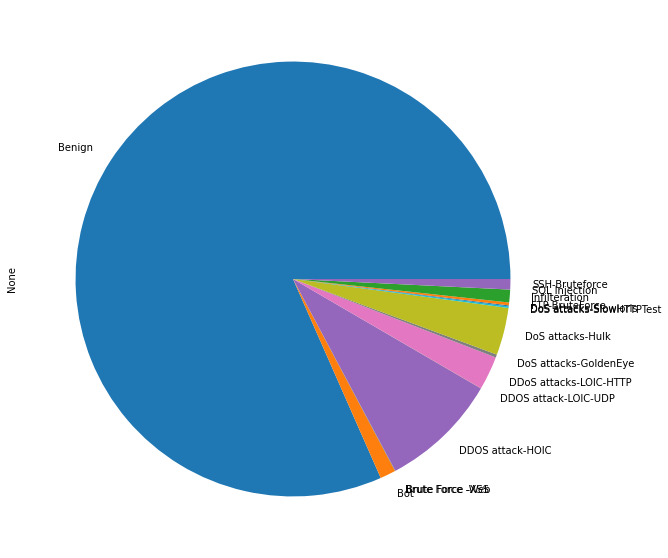

Attack
Benign                      10020849
Bot                           143097
Brute Force -Web                2143
Brute Force -XSS                 927
DDOS attack-HOIC             1080858
DDOS attack-LOIC-UDP            2112
DDoS attacks-LOIC-HTTP        307300
DoS attacks-GoldenEye          27723
DoS attacks-Hulk              432648
DoS attacks-SlowHTTPTest       14116
DoS attacks-Slowloris           9512
FTP-BruteForce                 25933
Infilteration                 116361
SQL Injection                    432
SSH-Bruteforce                 94979
dtype: int64


In [6]:
print('Generating test 2 data numpy arrays')


new_test_file = 'rb_r8_NF-CSE-CIC-IDS2018-v2.csv'
if p != 1:
    dir = folder

df = pd.read_csv(dir+new_test_file, usecols=['Label','Attack'])
print('p:', str(len(df[df['Label'] == 0].index)/len(df.index)))
count_series = df.groupby(['Attack']).size()
count_series.plot(kind='pie', figsize=(10,10))
plt.show()
print(count_series)
df = pd.read_csv(dir+new_test_file, dtype=d, usecols=headers)

X_1, y_1 = df_to_np(df)
X_1 = scaler.transform(X_1)
y_1, a_1 = seperate_label_attack(y_1)

np.save(folder+'X_1.npy', X_1)
np.save(folder+'y_1.npy', y_1)
np.save(folder+'a_1.npy', a_1)

Generating test 2 data numpy arrays
p: 0.9325517003527855


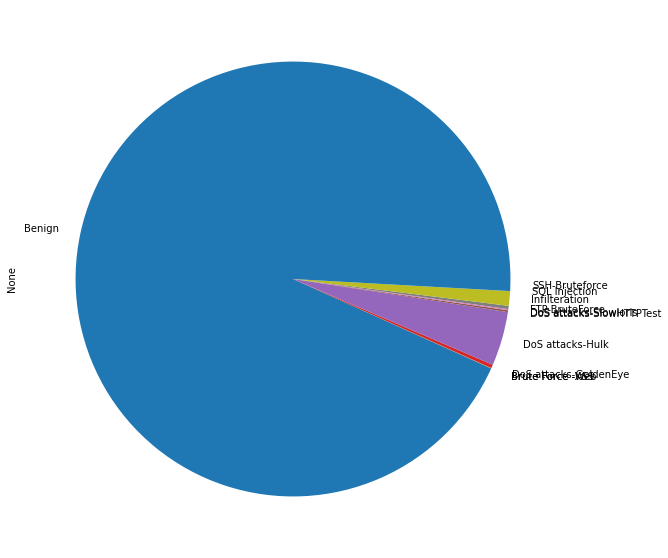

Attack
Benign                      10020849
Brute Force -Web                2143
Brute Force -XSS                 927
DoS attacks-GoldenEye          27723
DoS attacks-Hulk              432648
DoS attacks-SlowHTTPTest       14116
DoS attacks-Slowloris           9512
FTP-BruteForce                 25933
Infilteration                 116361
SQL Injection                    432
SSH-Bruteforce                 94979
dtype: int64


7147

In [7]:
print('Generating test 2 data numpy arrays')
df = pd.read_csv(dir+new_test_file, dtype=d, usecols=headers)
df.drop(df[df['Attack'] == 'DDOS attack-HOIC'].sample(frac=1).index, inplace=True)
df.drop(df[df['Attack'] == 'DDoS attacks-LOIC-HTTP'].sample(frac=1).index, inplace=True)
df.drop(df[df['Attack'] == 'DDOS attack-LOIC-UDP'].sample(frac=1).index, inplace=True)
df.drop(df[df['Attack'] == 'Bot'].sample(frac=1).index, inplace=True)
print('p:', str(len(df[df['Label'] == 0].index)/len(df.index)))
count_series = df.groupby(['Attack']).size()
count_series.plot(kind='pie', figsize=(10,10))
plt.show()
print(count_series)

X_1_ar, y_1_ar = df_to_np(df)
X_1_ar = scaler.transform(X_1_ar)
y_1_ar, a_1_ar = seperate_label_attack(y_1_ar)

np.save(folder+'X_1_ar.npy', X_1_ar)
np.save(folder+'y_1_ar.npy', y_1_ar)
np.save(folder+'a_1_ar.npy', a_1_ar)


del X_1_ar
del y_1_ar
del a_1_ar
del df
gc.collect()